# <div align="center">Data Science with Stock Data - Custom k-nearest Neighbors (kNN)</div>
### <div align="center">Author: <a href="https://www.linkedin.com/in/kaming-yip-22b03a1a0/">Kaming Yip</a>&emsp;&emsp;Date: Mar. 01, 2020</div>

Before start reading this file, you are suggested to read the project instruction in the <a href="https://github.com/KamingYip/Data-Science-with-Stock-Data/blob/master/README.md">README.md</a> file.

In this file, we will implement custom <b>k-nearest Neighbors (kNN)</b> in our selected stock data, YELP, for two years 2018 and 2019, to predict labels and compute the model performance of trading strategies based on the labels. The classifier will generalize the standard kNN classifier as it will allow different distance metrics.

First, we scrape the historical data from <a href="https://finance.yahoo.com/quote/YELP?p=YELP&.tsrc=fin-srch-v1">yahoo web</a> and manipulate the data to create desirable columns.

In [1]:
from pandas_datareader import data as web
import pandas as pd
import numpy as np

In [2]:
def get_stock(ticker, start_date, end_date):
    try:
        df = web.get_data_yahoo(ticker, start=start_date, end=end_date)
        df['Return'] = df['Adj Close'].pct_change()
        df['Return'].fillna(0, inplace = True)
        df['Return'] = 100.0 * df['Return']
        df['Return'] = df['Return'].round(3)
        df['Date'] = df.index
        df['Date'] = pd.to_datetime(df['Date'])
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year
        df['Day'] = df['Date'].dt.day
        for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
            df[col] = df[col].round(2)
        df['Weekday'] = df['Date'].dt.weekday_name  
        df['Week_Number'] = df['Date'].dt.strftime('%U')
        df['Year_Week'] = df['Date'].dt.strftime('%Y-%U')
        col_list = ['Date', 'Year', 'Month', 'Day', 'Weekday', 'Week_Number', 'Year_Week',
                    'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Return']
        df = df[col_list]
        return df
    except Exception as error:
        print(error)
        return None

ticker='YELP'
df = get_stock(ticker, start_date='2017-01-01', end_date='2019-12-31')
df.head()

,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,Low,Close,Volume,Adj Close,Return
Date,,,,,,,,,,,,,,
2017-01-03,2017-01-03,2017,1,3,Tuesday,01,2017-01,38.50,39.14,37.56,38.22,2391900,38.22,0.000
2017-01-04,2017-01-04,2017,1,4,Wednesday,01,2017-01,38.28,39.44,38.28,39.42,2238000,39.42,3.140
2017-01-05,2017-01-05,2017,1,5,Thursday,01,2017-01,39.20,40.18,38.81,39.62,2310900,39.62,0.507
2017-01-06,2017-01-06,2017,1,6,Friday,01,2017-01,39.80,39.96,39.21,39.31,1230200,39.31,-0.782
2017-01-09,2017-01-09,2017,1,9,Monday,02,2017-02,39.49,40.41,39.31,40.14,1719000,40.14,2.111


Then we will create the mean return and volatility values for each week. These two features will be our main independent variables to train the model.

In [3]:
def weekly_return_volatility(data, start_date, end_date):
    df_2 = data[data['Date'] >= start_date]
    df_2 = df_2[df_2['Date'] <= end_date]
    df_2 = df_2[['Year', 'Week_Number', 'Open', 'Adj Close', 'Return']]
    df_2.index = range(len(df_2))
    df_grouped = df_2.groupby(['Year', 'Week_Number'])['Return'].agg([np.mean, np.std])
    df_grouped.reset_index(['Year', 'Week_Number'], inplace=True)
    df_grouped.rename(columns={'mean': 'mean_return', 'std':'volatility'}, inplace=True)
    df_grouped.fillna(0, inplace=True)
    df_grouped["Open"] = df_2.groupby(["Year", "Week_Number"])["Open"].head(1).\
                                      reset_index(drop = True).copy()
    df_grouped["Adj Close"] = df_2.groupby(["Year", "Week_Number"])["Adj Close"].tail(1).\
                                           reset_index(drop = True).copy()
    return df_grouped

df_weekly = weekly_return_volatility(df, start_date='2018-01-01', end_date='2019-12-31')
df_weekly.head()

,Year,Week_Number,mean_return,volatility,Open,Adj Close
0,2018,00,0.7235,1.677695,42.06,43.17
1,2018,01,1.0174,1.548486,43.03,45.39
2,2018,02,-1.4135,2.049766,45.39,42.85
3,2018,03,0.6000,1.871186,42.70,44.12
4,2018,04,0.3262,2.706359,44.06,44.78


For each week, we will label as "green" or "red":
* a "green" week means that it was a good week to be invested for that week (from Friday to Friday)
* a "red" week means that it was <b>NOT</b> a good week (e.g. prices fell or there was too much volatility in the price)

In this project, we will label those weeks with mean return higher than or equal to the 50-percentile threshold as well as with volatility not higher than the 50-percentile threshold of that year as "Green"; otherwise, they will be labeled as "Red".

In [4]:
def weekly_label(data, year):
    df_label = data[data["Year"] == year].copy()
    mean_return_percent50 = np.percentile(df_label["mean_return"], 50)
    volatility_percent50 = np.percentile(df_label["volatility"], 50)      
    df_label["True Label"] = np.where((df_label["mean_return"] >= mean_return_percent50) & \
                                      (df_label["volatility"] <= volatility_percent50), "Green", "Red")
    return df_label

df_labeling = pd.DataFrame()
for year in [2018, 2019]:
    df_year_label = weekly_label(df_weekly, year)
    label_count = df_year_label.groupby("True Label")["True Label"].size().to_frame(name = "Freq")       
    df_labeling = df_labeling.append(df_year_label, ignore_index = True)

df_labeling.head()

,Year,Week_Number,mean_return,volatility,Open,Adj Close,True Label
0,2018,00,0.7235,1.677695,42.06,43.17,Green
1,2018,01,1.0174,1.548486,43.03,45.39,Green
2,2018,02,-1.4135,2.049766,45.39,42.85,Red
3,2018,03,0.6000,1.871186,42.70,44.12,Red
4,2018,04,0.3262,2.706359,44.06,44.78,Red


Let's take a look at the label distribution in training data and testing data.

In [5]:
train_df = df_labeling[df_labeling["Year"] == 2018].copy()
test_df = df_labeling[df_labeling["Year"] == 2019].copy()

train_test_sum = pd.DataFrame({
    "Dataset": ["Training", "Testing", "Total"],
    "Week Num": ["{0:,}({1:.2f}%)".format(len(train_df), len(train_df)/len(df_labeling)*100),
                 "{0:,}({1:.2f}%)".format(len(test_df), len(test_df)/len(df_labeling)*100),
                 "{0:,}({1:.2f}%)".format(len(df_labeling), len(df_labeling)/len(df_labeling)*100)],
    "Green Label": ["{0:,}({1:.2f}%)".format(len(train_df[train_df["True Label"] == "Green"]),
                                             len(train_df[train_df["True Label"] == "Green"])/len(train_df)*100),
                    "{0:,}({1:.2f}%)".format(len(test_df[test_df["True Label"] == "Green"]),
                                             len(test_df[test_df["True Label"] == "Green"])/len(test_df)*100),
                    "{0:,}({1:.2f}%)".format(len(df_labeling[df_labeling["True Label"] == "Green"]),
                                             len(df_labeling[df_labeling["True Label"] == "Green"])/len(df_labeling)*100)],
    "Red Label": ["{0:,}({1:.2f}%)".format(len(train_df[train_df["True Label"] == "Red"]),
                                           len(train_df[train_df["True Label"] == "Red"])/len(train_df)*100),
                  "{0:,}({1:.2f}%)".format(len(test_df[test_df["True Label"] == "Red"]),
                                           len(test_df[test_df["True Label"] == "Red"])/len(test_df)*100),
                  "{0:,}({1:.2f}%)".format(len(df_labeling[df_labeling["True Label"] == "Red"]),
                                           len(df_labeling[df_labeling["True Label"] == "Red"])/len(df_labeling)*100)]})

train_test_sum

,Dataset,Week Num,Green Label,Red Label
0,Training,53(50.00%),16(30.19%),37(69.81%)
1,Testing,53(50.00%),14(26.42%),39(73.58%)
2,Total,106(100.00%),30(28.30%),76(71.70%)


By far, we have completed the data preparation. From the raw data, we have conducted feature engineering to create new features that we would use in the modeling, calculated the average return and volatility for each week, and labeled each week as "Green" or "Red" by a predetermined rule. We will then use the labeled dataset in the following sections.

We will first define our confusion matrix function to better visualize the model performance, including Accuracy, Recall, Precision, and F1 score.

In [6]:
from tabulate import tabulate
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

In [7]:
def designed_confusion_matrix(train_actual, train_pred, train_title,
                              test_actual, test_pred, test_title,
                              classes, sup_title):
    fig = plt.figure(figsize = (8, 5))
    fig.suptitle(sup_title, fontweight = "bold")
    
    fig.add_subplot(221)
    train_cm = confusion_matrix(train_actual, train_pred)
    plt.imshow(train_cm, interpolation = "nearest", cmap = "Reds")
    plt.title(train_title, fontsize = 10)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(train_cm.shape[0]), range(train_cm.shape[1])):
        plt.text(j, i, format(train_cm[i, j], "d"), horizontalalignment = "center", color = "black")
    plt.tight_layout()
    plt.ylabel("Actual Class")      
    plt.xlabel("Predicted Class")
            
    fig.add_subplot(222)
    test_cm = confusion_matrix(test_actual, test_pred)
    plt.imshow(test_cm, interpolation = "nearest", cmap = "Reds")
    plt.title(test_title, fontsize = 10)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(test_cm.shape[0]), range(test_cm.shape[1])):
        plt.text(j, i, format(test_cm[i, j], "d"), horizontalalignment = "center", color = "black")
    plt.tight_layout()
    plt.ylabel("Actual Class")
    plt.xlabel("Predicted Class")
    
    fig.subplots_adjust(top = 0.85)
    
    plt.show()
            
    stats_summary = pd.DataFrame(columns = ["Training Data", "Testing Data"],
                                 index = ["Accuracy", "Recall", "Precision", "F1 Score"])
    stats_set = [[train_actual, train_pred], [test_actual, test_pred]]
    for i, ele in enumerate(stats_set):
        stats_summary.iloc[:, i] = [accuracy_score(ele[0], ele[1]),
                                    recall_score(ele[0], ele[1]),
                                    precision_score(ele[0], ele[1]),
                                    f1_score(ele[0], ele[1])]
    print(tabulate(stats_summary, headers = "keys", numalign = "right", floatfmt = ".3f"), end = "\n\n\n")

Instead of using the existing KNeighborsClassifier in sklearn module, we will create our own kNN classifier from scratch. Our designed classifier will generalize the standard kNN classifier as it will allow different distance metrics.

As before, <i>k</i> is the number of neighbors and <i>p</i> ≥ 1 is the parameter in the Minkowski distance metric. Recall that Minkowski <i>p</i>-norm (distance) <i>d<sub>p</sub>(A, B)</i> from point <i>A = (x<sub>1</sub>, y<sub>1</sub>)</i> to point <i>B = (x<sub>2</sub>, y<sub>2</sub>)</i> is defined as follows:

<a href="https://www.codecogs.com/eqnedit.php?latex=d_{p}(A,&space;B)&space;=&space;(|x_{1}&space;-&space;x_{2}|^{p}&space;&plus;&space;|y_{1}&space;-&space;y_{2}|^{p})^{1/p}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?d_{p}(A,&space;B)&space;=&space;(|x_{1}&space;-&space;x_{2}|^{p}&space;&plus;&space;|y_{1}&space;-&space;y_{2}|^{p})^{1/p}" title="d_{p}(A, B) = (|x_{1} - x_{2}|^{p} + |y_{1} - y_{2}|^{p})^{1/p}" /></a>

For <i>p</i> = 2 this gives Euclidean distance:

<a href="https://www.codecogs.com/eqnedit.php?latex=d_{2}(A,&space;B)&space;=&space;(|x_{1}&space;-&space;x_{2}|^{2}&space;&plus;&space;|y_{1}&space;-&space;y_{2}|^{2})^{1/2}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?d_{2}(A,&space;B)&space;=&space;(|x_{1}&space;-&space;x_{2}|^{2}&space;&plus;&space;|y_{1}&space;-&space;y_{2}|^{2})^{1/2}" title="d_{2}(A, B) = (|x_{1} - x_{2}|^{2} + |y_{1} - y_{2}|^{2})^{1/2}" /></a>

whereas for <i>p</i> = 1 this gives the "Manhattan" (street) distance:

<a href="https://www.codecogs.com/eqnedit.php?latex=d_{1}(A,&space;B)&space;=&space;|x_{1}&space;-&space;x_{2}|&space;&plus;&space;|y_{1}&space;-&space;y_{2}|" target="_blank"><img src="https://latex.codecogs.com/gif.latex?d_{1}(A,&space;B)&space;=&space;|x_{1}&space;-&space;x_{2}|&space;&plus;&space;|y_{1}&space;-&space;y_{2}|" title="d_{1}(A, B) = |x_{1} - x_{2}| + |y_{1} - y_{2}|" /></a>

We will implement the custom kNN classifier as a class.

In [8]:
class Custom_kNN:
    def __init__(self, number_neighbors_k, distance_parameter_p):
        self.k = number_neighbors_k
        self.p = distance_parameter_p
        self.predictors = None
        self.label = None
        
    def __str__(self):
        return "a custom kNN with k = {self.k} and p = {self.p}".format(self = self)
    
    def fit(self, X, Labels):
        import numpy as np
        import pandas as pd
        
        self.predictors = np.asarray(X)
        self.label = pd.DataFrame(Labels, columns = ["True Label"])
        
    def predict(self, new_x):
        import numpy as np
        from collections import Counter
        import pandas as pd
        
        y_pred = []
        for test_point in new_x:
            distances = []
            for train_point in self.predictors:
                distances.append(np.linalg.norm(test_point - train_point, ord = self.p))
            distances_df = pd.DataFrame(distances, columns = ["dist"], index = self.label.index).\
                           sort_values(by = ["dist"], axis = 0)[ : self.k]
            counter = Counter(self.label.iloc[distances_df.index]["True Label"])
            prediction = counter.most_common()[0][0]
            y_pred.append(prediction)
        return y_pred 

The kNN models will be trained by stock data in 2018 and different <i>p</i> values and <i>k</i> values will be tested against the training data and computed the accuracy of the custom kNN classifier.

In [9]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [10]:
X_train = train_df[["mean_return", "volatility"]].values
kNN_scaler = StandardScaler().fit(X_train)
X_train = kNN_scaler.transform(X_train)
y_train = train_df["True Label"].values
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)

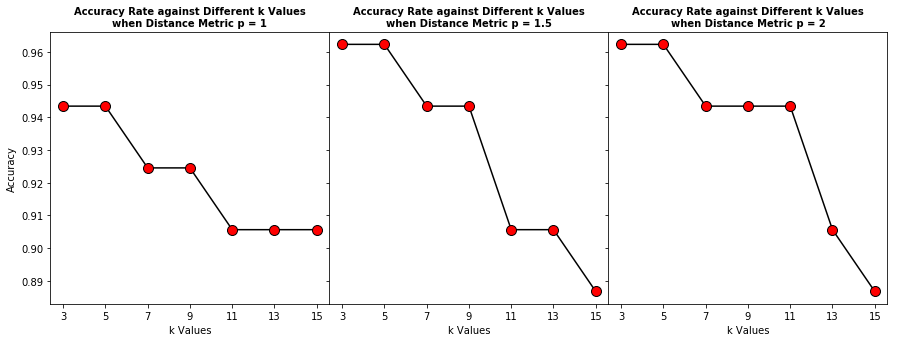

In [11]:
k_values = list(range(3, 17, 2))
p_values = [1, 1.5, 2]

optimal_k = pd.DataFrame(columns = ["p value", "k value", "accuracy"])

fig, axes = plt.subplots(1, 3, figsize = (15, 5), sharey = True, gridspec_kw = {"wspace": 0})

for index, p in enumerate(p_values):
    max_accuracy = 0.0
    accuracy_list = []
    
    for k in k_values:
        kNN_classifier = Custom_kNN(number_neighbors_k = k, distance_parameter_p = p)
        kNN_classifier.fit(X_train, y_train)
        y_train_pred = kNN_classifier.predict(X_train)
        accuracy = accuracy_score(y_train, y_train_pred)
        accuracy_list.append(accuracy)
        if accuracy >= max_accuracy:
            max_accuracy = accuracy
    
    optimal_k_dict = {k:accuracy for (k, accuracy) in enumerate(accuracy_list) if accuracy == max_accuracy}
    optimal_k_list = [k_values[i] for i in optimal_k_dict.keys()]
    optimal_k = optimal_k.append(pd.DataFrame({"p value": [p] * len(optimal_k_list),
                                               "k value": optimal_k_list,
                                               "accuracy": [max_accuracy] * len(optimal_k_list)}),
                                 ignore_index = True)
    
    axes[index].plot(k_values, accuracy_list, color = "black", marker = "o",
                     markerfacecolor = "red", markersize = 10)
    axes[index].set_title("Accuracy Rate against Different k Values\nwhen Distance Metric p = {0}".format(p),
                          fontweight = "bold", fontsize = 10)
    axes[index].set_xlabel("k Values")
    axes[index].set_xticks(k_values)

axes[0].set_ylabel("Accuracy")
plt.show()

As shown in the graphs above, no matter applying which distance metric, the best model performance occurs when <i>k</i> = 3 and <i>k</i> = 5, respectively. Furthermore, by comparing the performance between each <i>p</i> value, it is indicated that the models built by <i>p</i> = 1.5 and <i>p</i> = 2 (Euclidean distance) slightly outperforms the model built with <i>p</i> = 1 (Manhattan distance).

We then take the optimal k and p value sets to train the model by training data and test it by testing data and compare their model performance by confusion matrix.

In [12]:
X_test = test_df[["mean_return", "volatility"]].values
X_test = kNN_scaler.transform(X_test)
y_test = test_df["True Label"].values
y_test = le.transform(y_test)

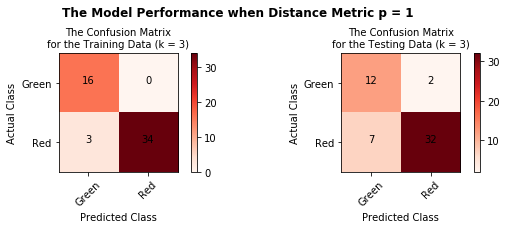

             Training Data    Testing Data
---------  ---------------  --------------
Accuracy             0.943           0.830
Recall               0.919           0.821
Precision            1.000           0.941
F1 Score             0.958           0.877




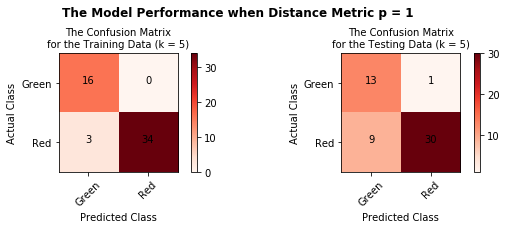

             Training Data    Testing Data
---------  ---------------  --------------
Accuracy             0.943           0.811
Recall               0.919           0.769
Precision            1.000           0.968
F1 Score             0.958           0.857




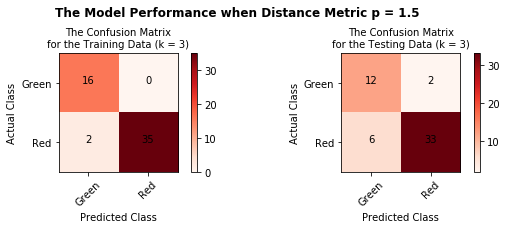

             Training Data    Testing Data
---------  ---------------  --------------
Accuracy             0.962           0.849
Recall               0.946           0.846
Precision            1.000           0.943
F1 Score             0.972           0.892




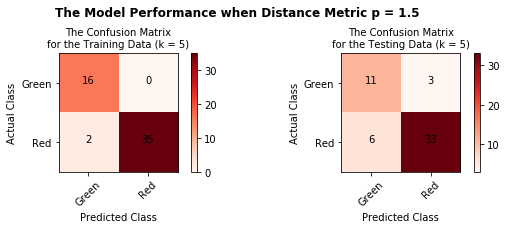

             Training Data    Testing Data
---------  ---------------  --------------
Accuracy             0.962           0.830
Recall               0.946           0.846
Precision            1.000           0.917
F1 Score             0.972           0.880




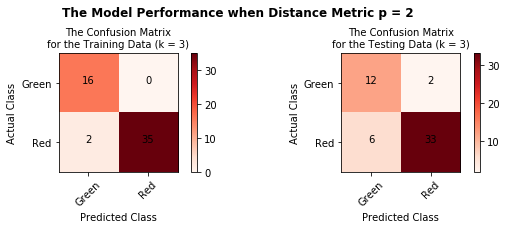

             Training Data    Testing Data
---------  ---------------  --------------
Accuracy             0.962           0.849
Recall               0.946           0.846
Precision            1.000           0.943
F1 Score             0.972           0.892




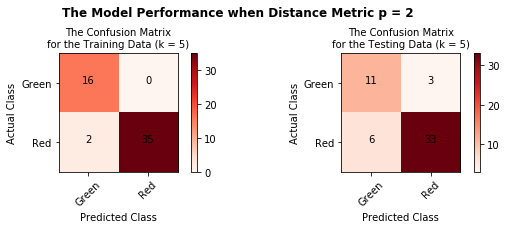

             Training Data    Testing Data
---------  ---------------  --------------
Accuracy             0.962           0.830
Recall               0.946           0.846
Precision            1.000           0.917
F1 Score             0.972           0.880




In [13]:
for i in range(len(optimal_k)):
    k = optimal_k.loc[i, "k value"]
    p = optimal_k.loc[i, "p value"]
    kNN_classifier = Custom_kNN(number_neighbors_k = k, distance_parameter_p = p)
    kNN_classifier.fit(X_train, y_train)
    y_train_pred = kNN_classifier.predict(X_train)
    y_test_pred = kNN_classifier.predict(X_test)
    #accuracy = accuracy_score(y_test, y_test_pred)
    designed_confusion_matrix(y_train, y_train_pred, "The Confusion Matrix\nfor the Training Data (k = {0})".format(k),
                              y_test, y_test_pred, "The Confusion Matrix\nfor the Testing Data (k = {0})".format(k),
                              ["Green", "Red"], "The Model Performance when Distance Metric p = {0}".format(p))

Surprisingly, with each distance metric, the kNN model built with k = 3 consistently outperforms the other model built with k = 5, even though the performance is really close to each other. Therefore, we will pick k = 3 as our optimal k value under each distance metric and apply them, respectively, in the trading strategy and test how they will perform in trading the stock.

In [14]:
def trade_with_labels(data, col_name):
    money = 100.0
    shares = 0.0
    position = "No"
    balance = []
    df_trade_labels = data.copy()
    for i in range(len(df_trade_labels) - 1):
        if i == 0:
            label = df_trade_labels.iloc[i][col_name]
            if label == "Green":
                shares = money / df_trade_labels.iloc[i]["Open"]
                money = 0.0
                position = "Long"
                balance.append(shares * df_trade_labels.iloc[i]["Adj Close"])
            else:
                balance.append(money)              
        else:
            label = df_trade_labels.iloc[i+1][col_name]
            if label == "Red":
                if position == "Long":
                    money = shares * df_trade_labels.iloc[i]["Adj Close"]
                    shares = 0.0
                    position = "No"
                balance.append(money)
            else:
                if position == "No":
                    shares = money / df_trade_labels.iloc[i+1]["Open"]
                    money = 0.0
                    position = "Long"
                balance.append(shares * df_trade_labels.iloc[i]["Adj Close"])            
    if position == "Long":
        balance.append(shares * df_trade_labels.iloc[-1]["Adj Close"])
    else:
        balance.append(money)
    return balance

def script_text(data, year, col_name):
    label_text_max = "{0} Week {1}\nmax ${2}".\
                     format(year, data.iloc[data[data["Year"] == year][col_name].idxmax()]["Week_Number"],
                            round(data[data["Year"] == year][col_name].max(), 2))
    label_x_max = data[data["Year"] == year][col_name].idxmax()
    label_y_max = round(data[data["Year"] == year][col_name].max(), 2)
            
    label_text_min = "{0} Week {1}\nmin ${2}".\
                     format(year,
                            data.iloc[data[data["Year"] == year][col_name].idxmin()]["Week_Number"],
                            round(data[data["Year"] == year][col_name].min(), 2))
    label_x_min = data[data["Year"] == year][col_name].idxmin()
    label_y_min = round(data[data["Year"] == year][col_name].min(), 2)
            
    label_text_final = "{0} Final:\n${1}".format(year, round(data[data["Year"] == year].iloc[-1][col_name], 2))
    label_x_final = data[data["Year"] == year].tail(1).index.values
    label_y_final = round(data[data["Year"] == year].iloc[-1][col_name], 2)
       
    return label_text_max, label_x_max, label_y_max,\
           label_text_min, label_x_min, label_y_min,\
           label_text_final, label_x_final, label_y_final

def buy_n_hold(data):
    money = 100.0
    shares = 0.0
    balance = []
    df_buy_hold = data.copy()  
    for i in range(len(df_buy_hold)):
        if i == 0:
            shares = money / df_buy_hold.iloc[i]["Open"]
        balance.append(shares * df_buy_hold.iloc[i]["Adj Close"])
    return balance

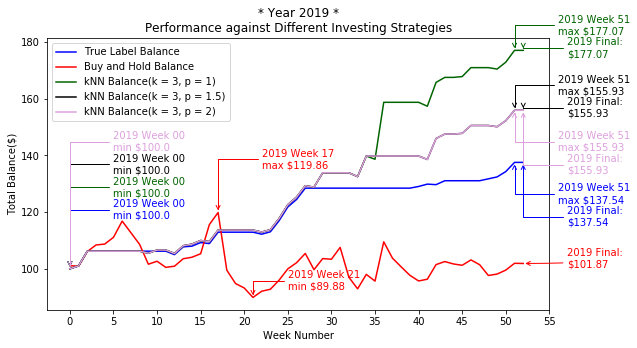

In [15]:
df_trading = df_labeling[df_labeling["Year"] == 2019].copy().reset_index(drop = True)
df_trading["True Label Balance"] = trade_with_labels(df_trading, "True Label")
df_trading["Buy and Hold Balance"] = buy_n_hold(df_trading)

k = 3
p_values = [1, 1.5, 2]
for p in p_values:
    kNN_classifier = Custom_kNN(number_neighbors_k = k, distance_parameter_p = p)
    kNN_classifier.fit(X_train, y_train)
    y_test_pred = kNN_classifier.predict(X_test)
    df_trading["kNN Label(k = {0}, p = {1})".format(k, p)] = le.inverse_transform(y_test_pred)
    df_trading["kNN Balance(k = {0}, p = {1})".format(k, p)] = \
        trade_with_labels(df_trading, "kNN Label(k = {0}, p = {1})".format(k, p))

fig, ax = plt.subplots(figsize = (9, 5))
       
label_text_max_2019, label_x_max_2019, label_y_max_2019,\
    label_text_min_2019, label_x_min_2019, label_y_min_2019,\
        label_text_final_2019, label_x_final_2019, label_y_final_2019 =\
            script_text(df_trading, 2019, "True Label Balance")
        
buy_hold_text_max_2019, buy_hold_x_max_2019, buy_hold_y_max_2019,\
    buy_hold_text_min_2019, buy_hold_x_min_2019, buy_hold_y_min_2019,\
        buy_hold_text_final_2019, buy_hold_x_final_2019, buy_hold_y_final_2019 =\
            script_text(df_trading, 2019, "Buy and Hold Balance")
        
p1_text_max_2019, p1_x_max_2019, p1_y_max_2019,\
    p1_text_min_2019, p1_x_min_2019, p1_y_min_2019,\
        p1_text_final_2019, p1_x_final_2019, p1_y_final_2019 =\
            script_text(df_trading, 2019, "kNN Balance(k = {0}, p = {1})".format(k, 1))
    
p15_text_max_2019, p15_x_max_2019, p15_y_max_2019,\
    p15_text_min_2019, p15_x_min_2019, p15_y_min_2019,\
        p15_text_final_2019, p15_x_final_2019, p15_y_final_2019 =\
            script_text(df_trading, 2019, "kNN Balance(k = {0}, p = {1})".format(k, 1.5))
    
p2_text_max_2019, p2_x_max_2019, p2_y_max_2019,\
    p2_text_min_2019, p2_x_min_2019, p2_y_min_2019,\
        p2_text_final_2019, p2_x_final_2019, p2_y_final_2019 =\
            script_text(df_trading, 2019, "kNN Balance(k = {0}, p = {1})".format(k, 2))

# Trading with True Labels
ax.plot(df_trading.index, "True Label Balance", data = df_trading, color = "blue")
        
ax.annotate(label_text_max_2019, xy = (label_x_max_2019, label_y_max_2019), xycoords = "data",
            xytext = (label_x_max_2019+5, label_y_max_2019-15), color = "blue",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "blue"),
            ha = "left", va = "bottom")
ax.annotate(label_text_min_2019, xy = (label_x_min_2019, label_y_min_2019), xycoords = "data",
            xytext = (label_x_min_2019+5, label_y_min_2019+17), color = "blue",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "blue"),
            ha = "left", va = "bottom")
ax.annotate(label_text_final_2019, xy = (label_x_final_2019, label_y_final_2019), xycoords = "data",
            xytext = (label_x_final_2019+5, label_y_final_2019-23), color = "blue",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "blue"),
            ha = "left", va = "bottom")
        
# Buy and Hold
ax.plot(df_trading.index, "Buy and Hold Balance", data = df_trading, color = "red")
        
ax.annotate(buy_hold_text_max_2019, xy = (buy_hold_x_max_2019, buy_hold_y_max_2019), xycoords = "data",
            xytext = (buy_hold_x_max_2019+5, buy_hold_y_max_2019+15), color = "red",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "red"),
            ha = "left", va = "bottom")
ax.annotate(buy_hold_text_min_2019, xy = (buy_hold_x_min_2019, buy_hold_y_min_2019), xycoords = "data",
            xytext = (buy_hold_x_min_2019+4, buy_hold_y_min_2019+2), color = "red",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "red"),
            ha = "left", va = "bottom")
ax.annotate(buy_hold_text_final_2019, xy = (buy_hold_x_final_2019, buy_hold_y_final_2019), xycoords = "data",
            xytext = (buy_hold_x_final_2019+5, buy_hold_y_final_2019-2), color = "red",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle3", color = "red"),
            ha = "left", va = "bottom")
        
# kNN model with k = 3, p = 1
ax.plot(df_trading.index, "kNN Balance(k = {0}, p = {1})".format(k, 1), data = df_trading, color = "darkgreen")
        
ax.annotate(p1_text_max_2019, xy = (p1_x_max_2019, p1_y_max_2019), xycoords = "data",
            xytext = (p1_x_max_2019+5, p1_y_max_2019+5), color = "darkgreen",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "darkgreen"),
            ha = "left", va = "bottom")
ax.annotate(p1_text_min_2019, xy = (p1_x_min_2019, p1_y_min_2019), xycoords = "data",
            xytext = (p1_x_min_2019+5, p1_y_min_2019+25), color = "darkgreen",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "darkgreen"),
            ha = "left", va = "bottom")
ax.annotate(p1_text_final_2019, xy = (p1_x_final_2019, p1_y_final_2019), xycoords = "data",
            xytext = (p1_x_final_2019+5, p1_y_final_2019-3), color = "darkgreen",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "darkgreen"),
            ha = "left", va = "bottom")
    
# kNN model with k = 3, p = 1.5
ax.plot(df_trading.index, "kNN Balance(k = {0}, p = {1})".format(k, 1.5), data = df_trading, color = "black")

ax.annotate(p15_text_max_2019, xy = (p15_x_max_2019, p15_y_max_2019), xycoords = "data",
            xytext = (p15_x_max_2019+5, p15_y_max_2019+5), color = "black",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "black"),
            ha = "left", va = "bottom")
ax.annotate(p15_text_min_2019, xy = (p15_x_min_2019, p15_y_min_2019), xycoords = "data",
            xytext = (p15_x_min_2019+5, p15_y_min_2019+33), color = "black",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "black"),
            ha = "left", va = "bottom")
ax.annotate(p15_text_final_2019, xy = (p15_x_final_2019, p15_y_final_2019), xycoords = "data",
            xytext = (p15_x_final_2019+5, p15_y_final_2019-3), color = "black",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "black"),
            ha = "left", va = "bottom")   
    
# kNN model with k = 3, p = 2
ax.plot(df_trading.index, "kNN Balance(k = {0}, p = {1})".format(k, 2), data = df_trading, color = "plum")
        
ax.annotate(p2_text_max_2019, xy = (p2_x_max_2019, p2_y_max_2019), xycoords = "data",
            xytext = (p2_x_max_2019+5, p2_y_max_2019-15), color = "plum",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "plum"),
            ha = "left", va = "bottom")
ax.annotate(p2_text_min_2019, xy = (p2_x_min_2019, p2_y_min_2019), xycoords = "data",
            xytext = (p2_x_min_2019+5, p2_y_min_2019+41), color = "plum",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "plum"),
            ha = "left", va = "bottom")
ax.annotate(p2_text_final_2019, xy = (p2_x_final_2019, p2_y_final_2019), xycoords = "data",
            xytext = (p2_x_final_2019+5, p2_y_final_2019-23), color = "plum",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "plum"),
            ha = "left", va = "bottom")

plt.title("* Year 2019 *\n" + "Performance against Different Investing Strategies", loc = "center")
plt.xlabel("Week Number")
plt.xticks(np.arange(0, 60, 5))
plt.ylabel("Total Balance($)")
plt.legend()
plt.show()

As displayed in the plot above, the best trading performance occurs when <i>k</i> = 3 and <i>p</i> = 1 in the kNN model, ending up with $177.07 at the end of the year when we invest $100 on the first trading day. The other two kNN models perform similarly in trading, earning $155.93 when the market closed at the last day. All the three kNN models provide better trading strategies than trading with the original labels and buy-and-hold strategy.

Interestingly, we can see the best model actually only predict one different label at the 36th week against the other kNN models, which turns out that the balance shot up by a staggering 14% approximately. Actually, it was the most profitable decision made in this strategy, making it outstand from the other trading strategies.